# Using notes' topic mixtures as features to develop models for predicting length of MV

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data

In [2]:
train_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/infer/train.csv'
train_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/train_bi_vent.txt'
# valid_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_other_15_thre_d2/infer/validation.csv'
# valid_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_other_15_thre_d2/validation_vent.txt'
test_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/infer/test.csv'
test_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/test_bi_vent.txt'

In [3]:
train_mixtures = pd.read_csv(train_mixture_filename, header=None)
bi_train_duration = pd.read_csv(train_duration_filename, header=None, sep=' ')
bi_train_duration = bi_train_duration[1].astype(int)
# valid_mixtures = pd.read_csv(valid_mixture_filename, header=None)
# valid_duration = pd.read_csv(valid_duration_filename, header=None, sep=' ')
# valid_duration = valid_duration[1].astype(np.float64)
test_mixtures = pd.read_csv(test_mixture_filename, header=None)
bi_test_duration = pd.read_csv(test_duration_filename, header=None, sep=' ')
bi_test_duration = bi_test_duration[1].astype(int)

In [174]:
train_mixtures.shape

(1545, 50)

In [175]:
bi_train_duration.shape

(1545,)

In [151]:
train_mixtures.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,6.169393,0.880430,0.598690,0.362789,0.416184,0.187921,0.665955,0.261223,6.708218,1.185520,...,0.224770,1.037896,0.316181,2.222237,2.559309,1.638421,2.698149,4.288230,0.307073,6.179341
1,1.250451,0.096186,3.431060,0.144998,8.455335,10.792283,3.112868,0.177797,6.234458,0.419704,...,83.139414,0.117779,0.226234,0.141875,0.205148,0.583311,3.067343,0.462541,12.394314,0.822867
2,11.855064,4.588003,150.448018,5.280188,2.262990,1.327328,3.911447,3.677770,25.427030,72.048828,...,3.126892,1.174563,0.841430,84.501553,2.419894,0.414802,1.340032,1.794121,1.088389,4.146183
3,29.423590,52.436662,29.355699,262.250371,2.700544,0.549543,490.783981,0.261389,0.473957,8.493560,...,0.241255,1.967094,0.095113,6.334435,3.305798,0.178678,1.427316,1.488076,0.158686,69.100347
4,9.046872,0.479707,2.254286,187.756879,786.144968,0.252679,0.578828,0.975533,367.764578,1.304707,...,0.140483,2.318918,0.239055,1.616026,0.721336,0.532097,0.405967,6.404681,0.125853,86.830035


In [155]:
normed_train_mixtures = pd.DataFrame(normalize(train_mixtures.iloc[:,2:51], norm='l1', axis=1))
normed_test_mixtures = pd.DataFrame(normalize(test_mixtures.iloc[:,2:51], norm='l1', axis=1))

## Convert to binarized duration

In [94]:
bi_train_duration = (train_duration > 7 * 24).astype(int)
bi_valid_duration = (valid_duration > 7 * 24).astype(int)
bi_test_duration = (test_duration > 7 * 24).astype(int)

## Logistic regression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, average_precision_score, precision_recall_curve, accuracy_score

In [5]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200)

In [6]:
lr.fit(train_mixtures, bi_train_duration)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
test_predictions_lr = lr.predict(test_mixtures)

In [8]:
print(average_precision_score(bi_test_duration, test_predictions_lr))
print(classification_report(bi_test_duration, test_predictions_lr))

0.5344561688311689
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        89
           1       0.61      0.60      0.60        65

    accuracy                           0.67       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.67      0.67      0.67       154



In [9]:
test_proba_lr = lr.predict_proba(test_mixtures)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(bi_test_duration, test_proba_lr, pos_label=1)

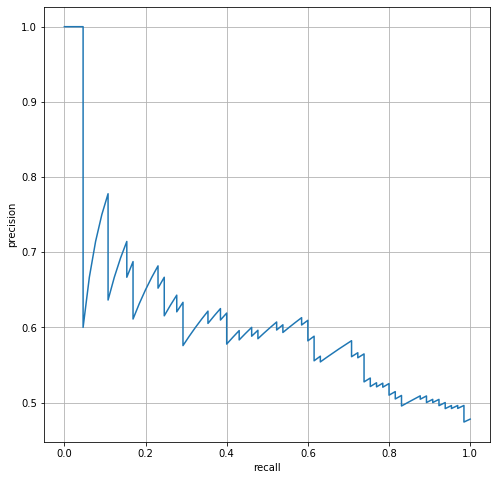

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(lr_recall, lr_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

## Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
GNB = GaussianNB()

In [25]:
GNB.fit(train_mixtures, bi_train_duration)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
test_predictions_GNB = GNB.predict(test_mixtures)

In [27]:
print(average_precision_score(bi_test_duration, test_predictions_GNB))
print(classification_report(bi_test_duration, test_predictions_GNB))

0.45545224006762464
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        89
           1       0.47      0.66      0.55        65

    accuracy                           0.55       154
   macro avg       0.56      0.56      0.55       154
weighted avg       0.58      0.55      0.54       154



## SVM

### Linear SVM

In [28]:
from sklearn.svm import LinearSVC

In [29]:
lsvm = LinearSVC()

In [30]:
lsvm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [31]:
test_predictions_lsvm = lsvm.predict(test_mixtures)

In [33]:
print(average_precision_score(bi_test_duration, test_predictions_lsvm))
print(classification_report(bi_test_duration, test_predictions_lsvm))

0.4116853734500793
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        89
           1       0.40      0.42      0.41        65

    accuracy                           0.49       154
   macro avg       0.48      0.48      0.48       154
weighted avg       0.49      0.49      0.49       154



### Non-linear SVM

In [34]:
from sklearn.svm import SVC

In [35]:
svm = SVC()

In [36]:
svm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [38]:
test_predictions_svm = svm.predict(test_mixtures)

In [40]:
print(average_precision_score(bi_test_duration, test_predictions_svm))
print(classification_report(bi_test_duration, test_predictions_svm))

0.5020979020979022
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        89
           1       1.00      0.14      0.24        65

    accuracy                           0.64       154
   macro avg       0.81      0.57      0.50       154
weighted avg       0.78      0.64      0.54       154



## Grid Search LR
Logistic regression seems to be the best classifier. See how good it can be.

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')

In [58]:
hyperparams = {
    'C': np.arange(0.6, 1.0, step=0.01),
    'max_iter': [100, 200, 300]
              }

In [59]:
searcher = GridSearchCV(estimator=estimator, n_jobs=12, param_grid=hyperparams, scoring='average_precision', cv=5)

In [60]:
searcher.fit(train_mixtures, bi_train_duration)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                         'max_iter

In [61]:
print(searcher.best_params_)

{'C': 0.8800000000000002, 'max_iter': 100}


In [62]:
print(searcher.best_score_)

0.5081135923225946


In [63]:
test_predictions_lrbest = searcher.best_estimator_.predict(test_mixtures)

In [64]:
print(average_precision_score(bi_test_duration, test_predictions_lrbest))
print(classification_report(bi_test_duration, test_predictions_lrbest))

0.5344561688311689
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        89
           1       0.61      0.60      0.60        65

    accuracy                           0.67       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.67      0.67      0.67       154



In [65]:
test_proba_lrbest = searcher.best_estimator_.predict_proba(test_mixtures)[:, 1]
precision, recall, _ = precision_recall_curve(bi_test_duration, test_proba_lrbest, pos_label=1)

In [33]:
import matplotlib.pyplot as plt

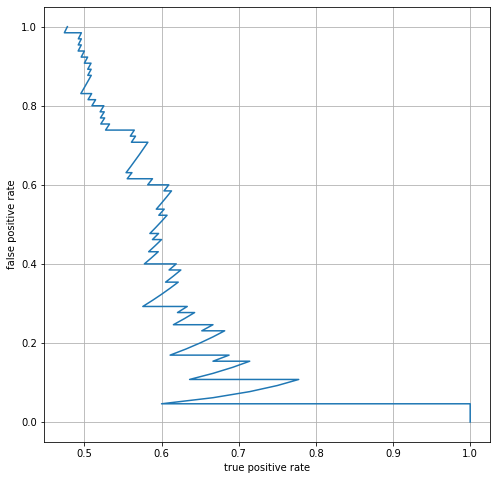

In [69]:
plt.figure(figsize=(8, 8))
plt.plot(precision, recall)
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.grid()

## Try AdaBoost

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [6]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear', C=1.5, max_iter=100, class_weight='balanced'), random_state=1)

In [7]:
ada.fit(train_mixtures, bi_train_duration)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.5,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001, verbose=0,
                                                     warm_start=False),
                   learning_r

In [9]:
test_predictions_ada = ada.predict(test_mixtures)

In [28]:
print(average_precision_score(bi_test_duration, test_predictions_ada))
print(classification_report(bi_test_duration, test_predictions_ada))

0.5215204150688022
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        89
           1       0.60      0.57      0.58        65

    accuracy                           0.66       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.65      0.66      0.65       154



## Try MLP (non-linear classifier)

In [13]:
from sklearn.neural_network import MLPClassifier

In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
#                    solver='lbfgs',
                   early_stopping=False,
                   max_iter=300,
                   random_state=1,
                   n_iter_no_change=20,
                   verbose=False)

In [17]:
mlp.fit(train_mixtures, bi_train_duration)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
mlp.n_iter_

213

In [19]:
test_predictions_mlp = mlp.predict(test_mixtures)

In [20]:
print(average_precision_score(bi_test_duration, test_predictions_mlp))
print(classification_report(bi_test_duration, test_predictions_mlp))

0.9293030046876202
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.95      0.95      0.95        65

    accuracy                           0.96       154
   macro avg       0.96      0.96      0.96       154
weighted avg       0.96      0.96      0.96       154



In [78]:
test_proba_mlp = mlp.predict_proba(test_mixtures)[:, 1]
mlp_precision, mlp_recall, _ = precision_recall_curve(bi_test_duration, test_proba_mlp, pos_label=1)

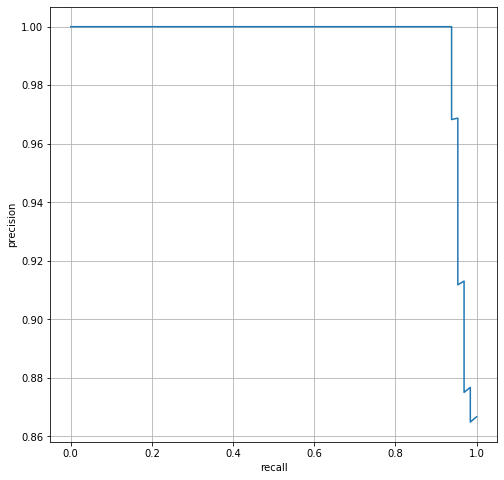

In [79]:
plt.figure(figsize=(8, 8))
plt.plot(mlp_recall, mlp_precision)
# plt.fill_between(mlp_recall, mlp_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

## Cross validation

In [23]:
import os
from sklearn.preprocessing import normalize

In [21]:
data_path = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2_cv'

In [24]:
fold_dfs = [pd.read_csv(os.path.join(data_path, 'infer', 'f' + str(idx) + '.csv'), header=None) for idx in range(1, 6)]

In [137]:
fold_dfs = [pd.DataFrame(normalize(fold_df.iloc[:,2:51], norm='l1', axis=1)) for fold_df in fold_dfs]

In [25]:
fold_dfs[0].head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.343478,2.383665,19.617464,2.550106,18.707967,77.299036,7.250984,36.368839,95.102842,332.668875,...,35.627812,2.331003,116.002313,56.723720,22.207594,25.918857,2.737948,305.919869,2.377683,18.944839
1,1.098619,0.590667,0.110441,1.018457,0.296803,0.316389,0.098031,0.696035,0.297607,0.377688,...,0.179764,28.915424,0.171989,0.718628,0.446589,0.764154,0.264989,0.417507,3.763927,0.317037
2,0.507173,32.324126,46.024242,4.583138,15.371187,20.643420,0.535632,364.999715,68.862911,43.689045,...,9.172962,0.419403,10.560775,65.837704,2.259125,42.783504,0.554554,11.783273,1.528829,49.117016
3,48.527377,1.283278,13.043862,1.041184,22.762191,1.198572,1.902370,4.589757,4.704269,4.792256,...,266.653403,0.818530,4.033464,238.413254,82.735814,1.256148,0.127385,11.764205,35.959983,214.736138
4,31.727704,157.518246,13.760755,15.476575,5.799357,3.933396,23.611588,3.323347,39.945223,17.453823,...,1.028413,7.208988,12.249694,1.473975,25.580835,303.726253,123.407849,6.214962,8.526866,10.041671


In [26]:
bi_durations = [pd.read_csv(os.path.join(data_path, 'f' + str(idx) + '_bi_vent.txt') , header=None, sep=' ') for idx in range(1, 6)] 
bi_durations = [bi_duration[1].astype(int) for bi_duration in bi_durations]

In [27]:
bi_durations[0]

0      0
1      1
2      0
3      1
4      1
      ..
273    0
274    1
275    1
276    0
277    0
Name: 1, Length: 278, dtype: int64

In [47]:
auprc = []
acc = []
for idx in range(5):
    cv_test_mixture = fold_dfs[idx].copy()
    bi_test_duration = bi_durations[idx].copy()
    train_fold_dfs = fold_dfs.copy()
    del train_fold_dfs[idx]
    cv_train_mixtures = pd.concat(train_fold_dfs)
    bi_train_durations = bi_durations.copy()
    del bi_train_durations[idx]
    bi_train_durations = pd.concat(bi_train_durations)

    mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
#                    solver='lbfgs',
                   early_stopping=False,
                   max_iter=800,
#                    random_state=1,
                   n_iter_no_change=40,
                   verbose=False)
    mlp.fit(cv_train_mixtures, bi_train_durations)
    test_predictions_mlp = mlp.predict(cv_test_mixture)
    auprc.append(average_precision_score(bi_test_duration, test_predictions_mlp))
    acc.append(accuracy_score(bi_test_duration, test_predictions_mlp))
    print('auprc:', auprc[-1])
    print('acc:', acc[-1])
    
print('mean auprc:', np.mean(auprc))
print('mean acc:', np.mean(acc))

auprc: 0.4203055673927757
acc: 0.5431654676258992
auprc: 0.4661673429878378
acc: 0.5539568345323741
auprc: 0.39290957570879087
acc: 0.5503597122302158
auprc: 0.44337744090441933
acc: 0.5971223021582733
auprc: 0.4752819302386573
acc: 0.5663082437275986
mean auprc: 0.43960837144649617
mean acc: 0.5621825120548722


### grid serach MLP

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
estimator = MLPClassifier(activation='relu',
                   random_state=1,
                   n_iter_no_change=40,
                   verbose=False)

In [56]:
gs_mixtures = pd.concat(fold_dfs, ignore_index=True)

In [58]:
gs_mixtures.shape

(1391, 50)

In [61]:
gs_bi_durations = pd.concat(bi_durations, ignore_index=True)

In [63]:
gs_bi_durations.shape

(1391,)

In [64]:
hyperparams = {'hidden_layer_sizes': [(l1, 20) for l1 in [40, 30]],
              'early_stopping': [True, False],
              'max_iter': [int(num) for num in range(300, 1000, 100)]}

In [65]:
searcher = GridSearchCV(estimator=estimator,
                       param_grid=hyperparams,
                       scoring='average_precision',
                       n_jobs=14,
                       cv=5)

In [ ]:
searcher.fit(gs_mixtures, gs_bi_durations)

In [69]:
searcher.best_params_

{'early_stopping': False, 'hidden_layer_sizes': (30, 20), 'max_iter': 600}

In [70]:
searcher.best_score_

0.47827543499956165